# Poetic Feature Accuracy (Section 6.1)

This notebook investigates the general accuracy for supervised classification algorithms when they are applied to the poetic features. Multiple classifiers are compared to try to ensure that the demonstrated accuracy is a result of the feature universe and not simply that the data is suited to one style of algorithm. Since the feature space is low dimensional (43 features) all that is done is to normalise it so that features like length (in lines) do not dominate the bulk of the features in the range \[0,1\].

It was initially hypothesised that restricting the contextual corpus to longer poems would improve the classification accuracy; put another way there were concerns that the results on shorter poems would be too variable to be useful. This turned out to be mostly not the case, although there are problems distinguishing between Ovid's _Tristia_ and _Ex Ponto_ (which is to be expected, as discussed in the paper).

Overall, the results show that the poetic features work at least as well as the LSA analysis. Although the classification accuracy by work is slightly lower, this is mainly due to the stylistic similarity between _Tristia_ and _Ex Ponto_. The classification results by author are very good, and commensurate with the LSA analysis (roughly 92-3%). Different algorithms work in different ways. Classifiers based on decision trees work well for the poetic features, with `ExtraTrees` being the best performer by a very slight margin.

In [10]:
import warnings
warnings.filterwarnings("ignore")

from mqdq import utils, babble, elegy, ngrams
from mqdq import line_analyzer as la
from mqdq import mahalanobis as maha

import bs4
import glob

import numpy as np
import pandas as pd
import scipy as sp

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, cross_validate
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from xgboost import XGBClassifier

In [ ]:
%load_ext rpy2.ipython

# Load Corpus

These XML files have all been downloaded from the [Pedecerto](http://www.pedecerto.eu/public/pagine/autori) collection, which offers fully scanned works from the [MQDQ](https://mizar.unive.it/mqdq/public/) corpus. Once again I'd like to thank those teams for providing such a fantastic resource under a permissive license. Some files in my corpus directory have been altered by me to remove a few problematic unicode characters that interfered with my own software.

In [2]:
collection = []

# Several lines need to be manually deleted, because when we make wide vectors
# we treat couplets as a unit (so we must have a matching number of H and P.)
# In some poems, we have corrupt lines, and so we delete the H that matches
# a corrupt P and vice versa.

ep = babble.bookbabs('corpus/OV-epis.xml', name="Ep.")
for b in ep:
    b.author = 'Ovid'
collection.extend(ep)

tr = babble.multi_bookbabs(sorted(glob.glob('corpus/OV-tri*.xml')), name="Tr.")
for b in tr:
    b.author = 'Ovid'
collection.extend(tr)

am = babble.multi_bookbabs(sorted(glob.glob('corpus/OV-amo*.xml')), name="Am.")
for b in am:
    b.author = 'Ovid'
collection.extend(am)

tib = babble.multi_bookbabs(sorted(glob.glob('corpus/TIB-ele*.xml')), name="Tib.")
del tib[1].raw_source[24]
for b in tib:
    b.author = 'Tibullus'
collection.extend(tib)

prop = babble.multi_bookbabs(sorted(glob.glob('corpus/PROP-ele*.xml')), name="Prop.")
for b in prop:
    b.author = 'Propertius'
del prop[55].raw_source[28]
collection.extend(prop)

cat = babble.bookbabs('corpus/CATVLL-carm.xml', name="Cat.")
cat_ele = [x for x in cat if x.elegiac and len(x) > 20]
for b in cat_ele:
    b.author = 'Catullus'
del cat_ele[3].raw_source[46]
collection.extend(cat_ele)

pon = babble.multi_bookbabs(sorted(glob.glob('corpus/OV-pon*.xml')), name="Pont.")
for b in pon:
    b.author = 'Ovid'
del pon[1].raw_source[8]
del pon[7].raw_source[18]
collection.extend(pon)

In [3]:
vecs = elegy.vectorise_babs(collection)
vecs

,Author,Work,Poem,H1SP,H2SP,H3SP,H4SP,H1CF,H2CF,H3CF,...,P4SC,P1WC,P2WC,P3WC,P4WC,ELC,RS,LEO,LEN,PFSD
0,Ovid,Ep.,Ep. 1,0.086207,0.500000,0.500000,0.448276,0.241379,0.706897,0.810345,...,0.0,0.206897,0.068966,0.396552,1.000000,0.094828,4.393948,0.739842,116,0.000000
1,Ovid,Ep.,Ep. 2,0.189189,0.527027,0.581081,0.391892,0.283784,0.743243,0.878378,...,0.0,0.202703,0.067568,0.337838,1.000000,0.114865,4.071062,1.027448,148,0.000000
2,Ovid,Ep.,Ep. 3,0.220779,0.493506,0.519481,0.480519,0.181818,0.597403,0.818182,...,0.0,0.116883,0.025974,0.324675,1.000000,0.090909,3.845700,0.484285,154,0.000000
3,Ovid,Ep.,Ep. 4,0.102273,0.511364,0.545455,0.465909,0.147727,0.659091,0.829545,...,0.0,0.215909,0.045455,0.329545,1.000000,0.073864,3.822098,0.893575,176,0.000000
4,Ovid,Ep.,Ep. 5,0.215190,0.455696,0.632911,0.417722,0.164557,0.658228,0.911392,...,0.0,0.202532,0.037975,0.341772,1.000000,0.056962,3.727347,0.713715,158,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,Ovid,Pont.,Pont. 4 12,0.120000,0.520000,0.720000,0.440000,0.240000,0.560000,0.920000,...,0.0,0.280000,0.040000,0.280000,1.000000,0.100000,3.073075,0.615696,50,0.000000
274,Ovid,Pont.,Pont. 4 13,0.160000,0.600000,0.680000,0.800000,0.280000,0.720000,0.920000,...,0.0,0.240000,0.080000,0.360000,0.880000,0.100000,5.954342,1.723439,50,0.775629
275,Ovid,Pont.,Pont. 4 14,0.129032,0.580645,0.548387,0.645161,0.096774,0.774194,0.903226,...,0.0,0.193548,0.032258,0.193548,0.903226,0.064516,3.314164,1.155196,62,0.591300
276,Ovid,Pont.,Pont. 4 15,0.095238,0.619048,0.666667,0.619048,0.285714,0.666667,0.714286,...,0.0,0.285714,0.095238,0.333333,0.952381,0.119048,3.695211,0.919168,42,0.425918


# The Poetic Features

Here is a summary of the poetic features, from the paper.

![table](./es_poetics_summary.png)

In [5]:
# A quick look at the corpus. This table is rendered in LaTeX for the
# paper.

pd.pivot_table(vecs, index=['Author','Work'], values=['LEN'],aggfunc=['count','min','max']).reset_index()

,Author,Work,count,min,max
,,,LEN,LEN,LEN
0,Catullus,Cat.,5,24,158
1,Ovid,Am.,49,18,114
2,Ovid,Ep.,21,116,376
3,Ovid,Pont.,46,22,166
4,Ovid,Tr.,50,26,578
5,Propertius,Prop.,91,6,150
6,Tibullus,Tib.,16,22,122


# Classifier Testing

A range of different classifiers are tested. In the paper (and figures below) I only compare four, but these extra results are provided for the sake of interest. There is no particular strategy in terms of which classifiers to test; I just wanted a decent mix of different algorithm types (metric distance, decision trees, linear function fiting, SVM...). `XGBoost` is a classifier that is currently fashionable, but reliable old SVM continues to perform very well.

In [6]:
pa = lambda: make_pipeline(
    StandardScaler(copy=False),
    PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, C=1.0, loss='squared_hinge')
)

et = lambda: make_pipeline(
    StandardScaler(copy=False),
    ExtraTreesClassifier(n_estimators=5000, max_features=17, criterion='gini', n_jobs=-1)
)

svm = lambda: make_pipeline(
    StandardScaler(copy=False),
    SVC(gamma='scale', kernel='rbf', C=128)
)

svml = lambda: make_pipeline(
    StandardScaler(copy=False),
    LinearSVC()
)

nc =  lambda: make_pipeline(
    StandardScaler(copy=False),
    NearestCentroid()
)

mnb =  lambda: make_pipeline(
    # don't centre the data around 0, otherwise
    # the MultinomialNB classifier breaks
    StandardScaler(with_mean=False),
    MultinomialNB()
)

xgbl = lambda: make_pipeline(
    StandardScaler(copy=False),
    XGBClassifier(
        booster='gblinear',
        objective="multi:softprob",
        eval_metric='merror',
        use_label_encoder=False
    )
)

xgbt = lambda: make_pipeline(
    StandardScaler(copy=False),
    XGBClassifier(
        booster='gbtree',
        objective="multi:softprob",
        eval_metric='merror',
        use_label_encoder=False
    )
)

CLASSIFIERS = [
    ('PassiveAggressive', pa),
    ('MultinomialNB', mnb),
    ('ExtraTrees', et),
    ('XGBoost (Linear)',xgbl),
    ('XGBoost (Tree)',xgbt),
    ('SVM', svm),
    ('SVM (Linear)', svml),
    ('NearestCentroid', nc),

]

In [7]:
def test_clfs(clfs, corp, feats, by, cutoff=0, seed=None, samps=20):
    """
    Test the given classifiers on a corpus.
    
    Multi-label fitting strategy is up to each classifier.
    """
    res = []
    # this makes a seeded rng, instead of seeding the ShuffleSplit
    # with the same value each time, which seems slightly cleaner.
    rng = np.random.RandomState(seed=seed)
    for (name, c) in clfs:
        trimmed = corp[corp.LEN >= cutoff]
        # XGBoost doesn't like string labels ¯\_(ツ)_/¯ 
        f, _ = trimmed[by].factorize()
        X,y = trimmed[feats], pd.Series(f)
        cv = StratifiedShuffleSplit(n_splits=samps, test_size=0.2, random_state=rng)
        # note to self: don't run parallel jobs if you have a seeded rng >:(
        jobs = -1
        if seed:
            jobs = 1
        samp_res = cross_val_score(c(), X, y, cv=cv, n_jobs=jobs, scoring='f1_weighted')
        m = sp.mean(samp_res)
        ci = sp.stats.t.interval(
            alpha=0.95,
            df=len(samp_res)-1,
            loc=m,
            scale=sp.stats.sem(samp_res)
        ) 
        res.append({'Classifier':name, 'Score':m, 'Cutoff': cutoff, 'CILow':ci[0], 'CIHigh':ci[1]})
    return pd.DataFrame(res)

In [8]:
cols = list(vecs.columns[3:])

In [12]:
test_bywork = test_clfs(CLASSIFIERS, vecs, cols, 'Work', cutoff=0, samps=100)

In [13]:
test_bywork.sort_values(by=['Score'])

,Classifier,Score,Cutoff,CILow,CIHigh
3,XGBoost (Linear),0.636379,0,0.626633,0.646124
0,PassiveAggressive,0.651348,0,0.641014,0.661682
6,SVM (Linear),0.657721,0,0.646120,0.669322
1,MultinomialNB,0.659667,0,0.649963,0.669372
4,XGBoost (Tree),0.664803,0,0.654090,0.675516
5,SVM,0.693458,0,0.683028,0.703889
7,NearestCentroid,0.696850,0,0.687006,0.706694
2,ExtraTrees,0.697942,0,0.687373,0.708511


In [14]:
test_byauth = test_clfs(CLASSIFIERS, vecs, cols, 'Author', cutoff=0, samps=100)

In [15]:
test_byauth.sort_values(by=['Score'])

,Classifier,Score,Cutoff,CILow,CIHigh
1,MultinomialNB,0.895064,0,0.887604,0.902524
6,SVM (Linear),0.908372,0,0.902221,0.914524
0,PassiveAggressive,0.913933,0,0.907624,0.920243
4,XGBoost (Tree),0.920222,0,0.914338,0.926106
2,ExtraTrees,0.924662,0,0.918757,0.930567
5,SVM,0.930515,0,0.925118,0.935912
7,NearestCentroid,0.938343,0,0.933186,0.943500
3,XGBoost (Linear),0.939932,0,0.933891,0.945972


In [50]:
%%capture --no-display

# How much better would the results be if we didn't have stylistic
# confusion between Tristia and Ex Ponto? About 10%.

no_ht_test = test_clfs(CLASSIFIERS, vecs[(vecs.Work != 'Pont.')], cols, 'Work', cutoff=0, samps=100)

In [52]:
no_ht_test.sort_values(by=['Score'])

,Classifier,Score,Cutoff,CILow,CIHigh
3,XGBoost (Linear),0.728538,0,0.716574,0.740503
6,SVM (Linear),0.732362,0,0.720795,0.743928
0,PassiveAggressive,0.759503,0,0.748349,0.770657
1,MultinomialNB,0.759965,0,0.748618,0.771311
4,XGBoost (Tree),0.772075,0,0.760507,0.783642
7,NearestCentroid,0.799155,0,0.788731,0.809579
5,SVM,0.808835,0,0.799022,0.818648
2,ExtraTrees,0.813942,0,0.804797,0.823087


In [22]:
# Based on the scores for both label sets (Work and Author) these
# are the four classifiers I chose to graph for the minimum-size test

GRAPH_CLASSIFIERS = [
    ('PassiveAggressive', pa),
    ('XGBoost',xgbl),
    ('SVM', svm),
    ('NearestCentroid', nc),
]

In [ ]:
dfs = []
for n in range(0,80,5):
    dfs.append(test_clfs(GRAPH_CLASSIFIERS, vecs, cols, 'Work', cutoff=n, samps=100))
bywork = pd.concat(dfs)
bywork

In [32]:
bywork

,Classifier,Score,Cutoff,CILow,CIHigh
0,PassiveAggressive,0.657737,0,0.646286,0.669189
1,XGBoost,0.640013,0,0.628789,0.651236
2,SVM,0.692377,0,0.681962,0.702792
3,NearestCentroid,0.690447,0,0.679166,0.701729
0,PassiveAggressive,0.667721,5,0.656649,0.678793
...,...,...,...,...,...
3,NearestCentroid,0.592864,70,0.571272,0.614455
0,PassiveAggressive,0.573169,75,0.550324,0.596015
1,XGBoost,0.581570,75,0.559806,0.603335
2,SVM,0.614441,75,0.594682,0.634200


In [54]:
# How many works remain at each cutoff point?

dicts = []
for n in range(0,80,10):
    dicts.append({'Cutoff':n, 'N':len(vecs[vecs.LEN >= n])})
n_df = pd.DataFrame(dicts)
n_df

,Cutoff,N
0,0,278
1,10,277
2,20,270
3,30,236
4,40,194
5,50,156
6,60,113
7,70,90


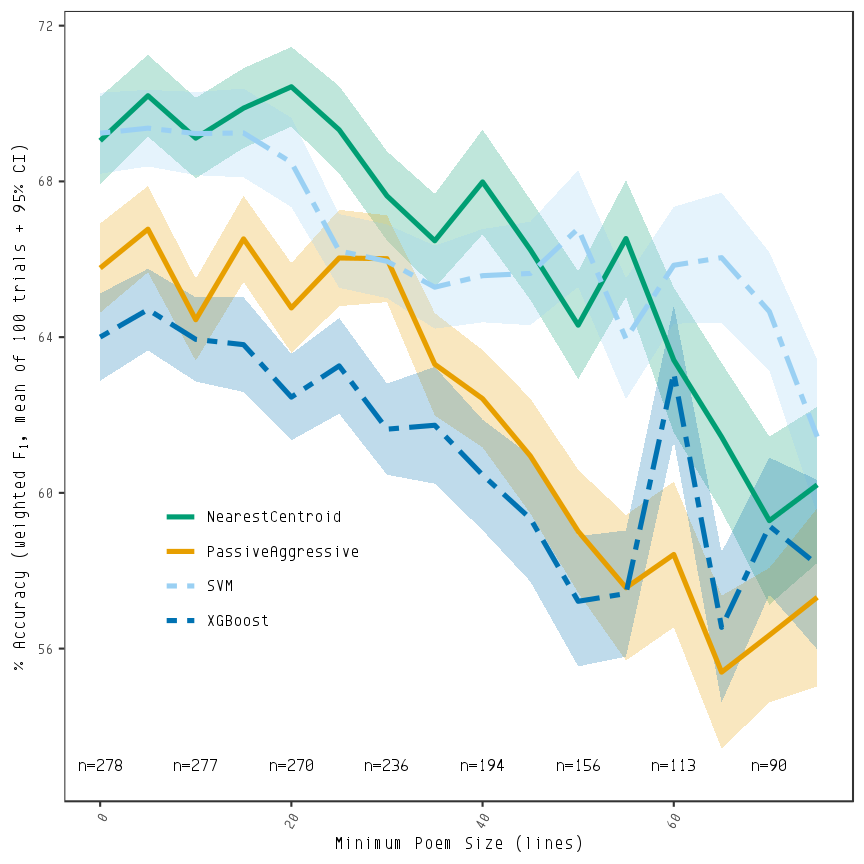

In [35]:
%%R -i bywork,n_df -h 6 -w 6 -u in -r 144
library(ggplot2)
library(extrafont)

cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")

ggplot(data=bywork, aes(x=Cutoff, y=Score*100)) +
geom_label(
    data=n_df,
    label.size=NA,
    aes(x=Cutoff, y=53, label=sprintf("n=%d",N)),
    family="Envy Code R",
    size=3
) +
geom_ribbon(
    aes(ymin=CILow*100, ymax=CIHigh*100, fill=Classifier), 
    alpha=0.25, show.legend=FALSE) +
geom_line(aes(color=Classifier,linetype=Classifier), size=1.2) +
guides(color = guide_legend(ncol=2)) +
labs(x="Minimum Poem Size (lines)",y=expression(paste("% Accuracy (weighted ",F[1],", mean of 100 trials + 95% CI)"))) +
theme_bw() +

theme(
    text = element_text(size=9, family="Envy Code R"),
    panel.grid.major=element_blank(),
    panel.grid.minor=element_blank(),
    legend.title=element_blank(),
    legend.position= c(0.25, 0.3),
    legend.text=element_text(size=8),
    axis.text.x = element_text(angle = 60, hjust = 1, vjust=1)
) +
scale_linetype_manual(values=c("solid", "solid", "twodash", "twodash")) +
scale_color_manual(values=cbbPaletteDark) +
scale_fill_manual(values=cbbPaletteDark)

# fn <- "../paper/figures/poetic_acc_work.pdf"
# ggsave(fn, dpi=600, width=6, height=6, device=cairo_pdf)

In [39]:
dfs = []
for n in range(0,80,5):
    dfs.append(test_clfs(GRAPH_CLASSIFIERS, vecs, cols, 'Author', cutoff=n, samps=100))
byauth = pd.concat(dfs)
byauth

,Classifier,Score,Cutoff,CILow,CIHigh
0,PassiveAggressive,0.913477,0,0.906443,0.920512
1,XGBoost,0.944305,0,0.938807,0.949803
2,SVM,0.926877,0,0.920513,0.933241
3,NearestCentroid,0.938966,0,0.933181,0.944752
0,PassiveAggressive,0.918112,5,0.912103,0.924121
...,...,...,...,...,...
3,NearestCentroid,0.948961,70,0.939741,0.958182
0,PassiveAggressive,0.929861,75,0.919326,0.940395
1,XGBoost,0.938299,75,0.927471,0.949127
2,SVM,0.915980,75,0.903723,0.928237


In [41]:
byauth

,Classifier,Score,Cutoff,CILow,CIHigh
0,PassiveAggressive,0.913477,0,0.906443,0.920512
1,XGBoost,0.944305,0,0.938807,0.949803
2,SVM,0.926877,0,0.920513,0.933241
3,NearestCentroid,0.938966,0,0.933181,0.944752
0,PassiveAggressive,0.918112,5,0.912103,0.924121
...,...,...,...,...,...
3,NearestCentroid,0.948961,70,0.939741,0.958182
0,PassiveAggressive,0.929861,75,0.919326,0.940395
1,XGBoost,0.938299,75,0.927471,0.949127
2,SVM,0.915980,75,0.903723,0.928237


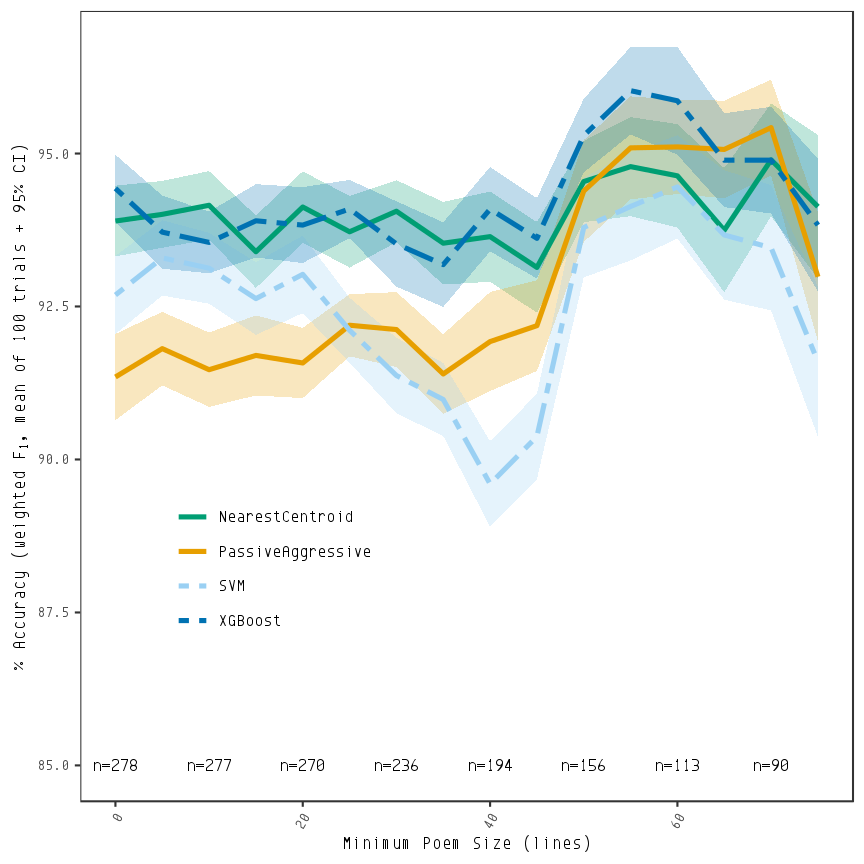

In [43]:
%%R -i byauth,n_df -h 6 -w 6 -u in -r 144

cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")

ggplot(data=byauth, aes(x=Cutoff, y=Score*100)) +
geom_label(
    data=n_df,
    label.size=NA,
    aes(x=Cutoff, y=85, label=sprintf("n=%d",N)),
    family="Envy Code R",
    size=3
) +
geom_ribbon(
    aes(ymin=CILow*100, ymax=CIHigh*100, fill=Classifier), 
    alpha=0.25, show.legend=FALSE) +
geom_line(aes(color=Classifier,linetype=Classifier), size=1.2) +

labs(x="Minimum Poem Size (lines)",y=expression(paste("% Accuracy (weighted ",F[1],", mean of 100 trials + 95% CI)"))) +
theme_bw() +
guides(color = guide_legend(ncol=2)) +

theme(
    text = element_text(size=9, family="Envy Code R"),
    panel.grid.major=element_blank(),
    panel.grid.minor=element_blank(),
    legend.title=element_blank(),
    legend.position= c(0.25, 0.3),
    legend.text=element_text(size=8),
    axis.text.x = element_text(angle = 60, hjust = 1, vjust=1)
) +

scale_linetype_manual(values=c("solid", "solid", "twodash", "twodash")) +
scale_color_manual(values=cbbPaletteDark) +
scale_fill_manual(values=cbbPaletteDark)

# fn <- "../paper/figures/poetic_acc_auth.pdf"
# ggsave(fn, dpi=600, width=6, height=6, device=cairo_pdf)

# Confusion Matrix

Finally, it is often useful to draw a confusion matrix to see which labels are the most distinctive. Here I examine just the accuracy per work. The matrix itself is the mean of 100 `StratifiedShuffleSplit` trials with a 20% holdout.

In [44]:
conf_matrix_list_of_arrays = []
X = vecs.drop(['Author','Work','Poem'], axis=1)
y = vecs.Work
names = sorted(y.unique())
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
clf = make_pipeline(
    StandardScaler(),
    NearestCentroid(),
)

for train_index, test_index in sss.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    conf_matrix = confusion_matrix(y_test, clf.predict(X_test))
    conf_matrix_list_of_arrays.append(conf_matrix)

In [45]:
conf_mat = np.mean(conf_matrix_list_of_arrays, axis=0)

In [46]:
# build the df for ggplot
cm_pct = [x/x.sum()*100 for x in conf_mat]
m = []
names = sorted(vecs['Work'].unique())
for y,arr in enumerate(cm_pct):
    for x,val in enumerate(arr):
        m.append({'x':names[x], 'y':names[y], 'val':val})
cmdf = pd.DataFrame(m)
cmdf.head()

,x,y,val
0,Am.,Am.,61.7
1,Cat.,Am.,0.0
2,Ep.,Am.,1.2
3,Pont.,Am.,11.3
4,Prop.,Am.,0.0


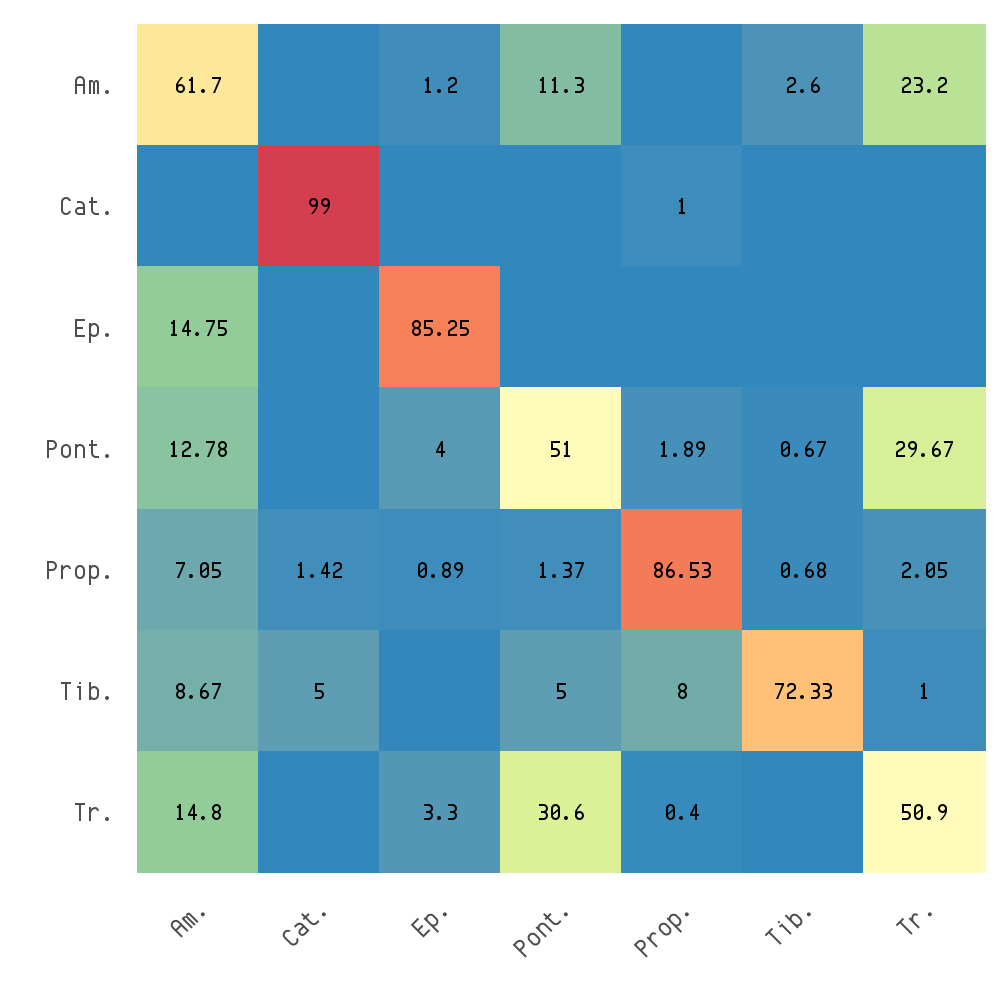

In [53]:
%%R -i cmdf -h 7 -w 7 -u in -r 144

library(tidyverse)
library(extrafont)

cmdf <- cmdf %>%
  mutate(x = factor(x, levels= unique(x)), # alphabetical order by default
         y = factor(y, levels = rev(unique(y)))) # force reverse alphabetical order
    
ggplot(cmdf, aes(x=x, y=y, fill=val)) +
# slightly overlap the tiles to avoid a visible border line
geom_tile(width=1.01, height=1.01) +
scale_fill_distiller(palette="Spectral", direction=-1) +
guides(fill=F) + # removing legend for `fill`
theme_minimal() +
# force it to be square
coord_equal() +
# supress output for 0
geom_text(
    aes(label=ifelse(round(cmdf$val,digits=2)==0, "", round(val,digits=2))),
    color="black",
    size=4,
    family="Envy Code R") + 

theme(
    text = element_text(size=16, family="Envy Code R"),
    panel.grid.minor=element_blank(),
    panel.grid.major=element_blank(),
    panel.border=element_blank(),
    legend.title=element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1, vjust=0.95),
    plot.title = element_text(hjust = 0.5),
    plot.subtitle = element_text(hjust = 0.5)
) +
labs(x="", y="")

# fn <- "../paper/figures/cm_poetics.pdf"
# ggsave(fn, dpi=600, width=7, height=7, device=cairo_pdf)